In [93]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
sys.path.append(f'/home/henrique/Documents/Atmos_Pandora/apc_atmo_repo/personal/Henrique/Analysis/pida/')
from anatree_class import Anatree
from PIDA_class import PIDA
from  ana_tools import *
import plotly.graph_objects as go


import mplhep
mplhep.style.use(mplhep.style.ROOT)
plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                    #  'figure.figsize': [14,6],
                     })


from pida_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
dfsimple_en = pl.read_parquet("./data/processed/nc/simple.parquet")
dfcomplex_en = pl.read_parquet("./data/processed/nc/complex.parquet")
dfcomplex_cheat_pi_en = pl.read_parquet("./data/processed/nc/complex_cheat_pi.parquet")
dfcomplex_cheat_pi_pr_en = pl.read_parquet("./data/processed/nc/complex_cheat_pi_pr.parquet")
dfcomplex_cheat_pr_en = pl.read_parquet("./data/processed/nc/complex_cheat_pr.parquet")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


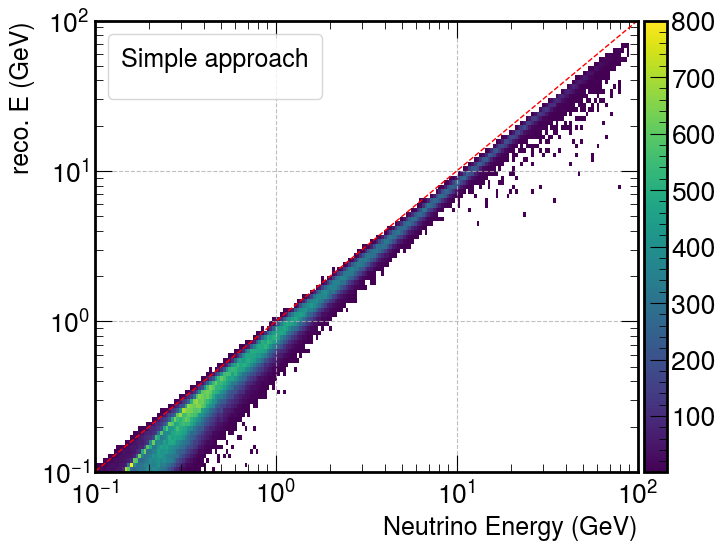

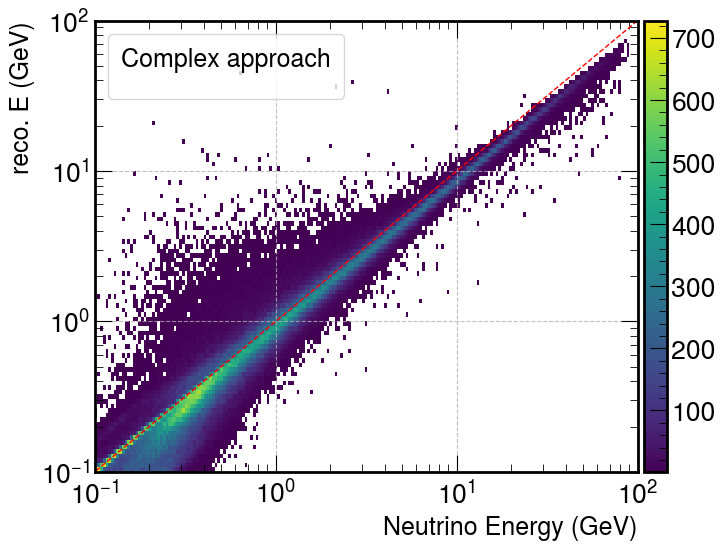

In [95]:
def plot_en_vs_en(Emu:pl.DataFrame,
                  lmethod,
                  x='enuvis_truth',
                  y='Etotal',
                  figsize=(8,6),
                  binsx=None,
                  binsy=None,
                  zscale='linear'
                  ):

    fig = plt.figure(figsize=figsize)
    if binsx is None:
        binsx = np.logspace(-1,2,200)
    if binsy is None:
        binsy = np.logspace(-1,2,200)
    # binsy = np.logspace(-1.1,np.log10(120),200)
    fontsize=18
    # fontsize='xx-large'
    plt.hist2d(Emu[x],Emu[y], bins=(binsx,binsy), norm=zscale, cmin=1, rasterized=True);
    # plt.plot([0,100],[0,100],'--', c='r')
    plt.xlabel('Neutrino Energy (GeV)', fontsize=fontsize)
    plt.ylabel(f'reco. E (GeV)', fontsize=fontsize)

    plt.yscale('log')
    plt.xscale('log')
    # plt.tick_params(labelsize=fontsize)

    cbar = plt.colorbar(pad=0.01)
    # cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    
    if lmethod != '':
        legend = plt.legend(frameon=True, title=lmethod, loc='upper left', bbox_to_anchor=(0,0.1,1,0.9))
        plt.setp(legend.get_title(),fontsize=fontsize)
    plt.plot([0,100],[0,100], 'r--', lw=1)
    # dunestyle.Preliminary(x=0.45, y=0.93, ax=plt.gca(), fontsize="xx-large")


dfsimple_en = dfsimple_en.filter(
    True,
    # ~pl.col('trkIsContained')
    # pl.col('hasmu')
)
binse=None
# binse=np.logspace(np.log10(50),2,100)
binsereco = binse
binsereco = np.logspace(-1,2,100)
plot_en_vs_en(dfsimple_en, binsy=binsereco, binsx=binse, lmethod='Simple approach', zscale='linear')
plot_en_vs_en(dfcomplex_en, binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale='linear')
# plot_en_vs_en(dfcomplex_en_2, binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale='linear')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(1, 0, 'Hadronic True Energy [GeV]')

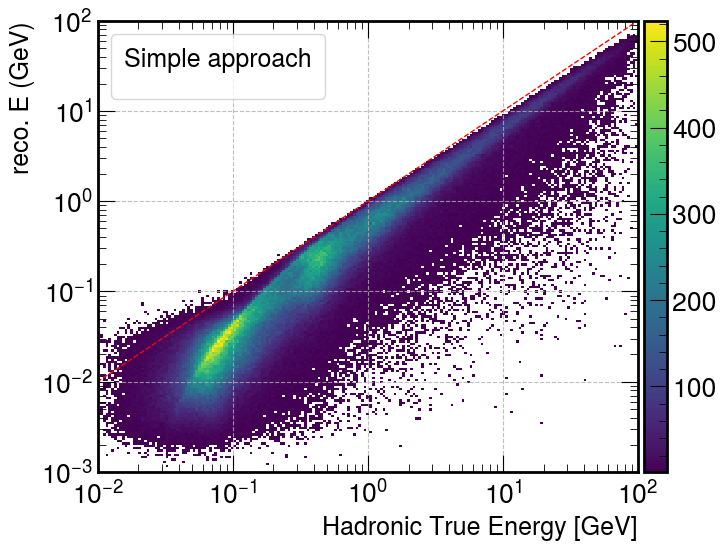

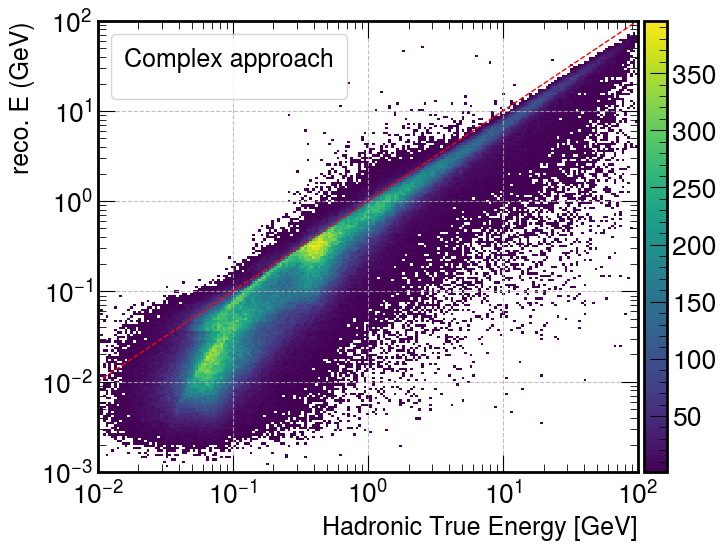

In [97]:
binse=None
binse=np.logspace(-2,2,200)
binsereco = binse
binsereco=np.logspace(-3,2,200)
# binsereco = np.logspace(-1,2,100)
plot_en_vs_en(dfsimple_en, x='had_truth', y='Ehad', binsy=binsereco, binsx=binse, lmethod='Simple approach', zscale='linear')
plt.xlabel('Hadronic True Energy [GeV]')
plot_en_vs_en(dfcomplex_en, x='had_truth', y='Ehad', binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale='linear')
plt.xlabel('Hadronic True Energy [GeV]')

In [98]:
from scipy.stats import binned_statistic
def plot_res_scatter(x,
                    y,
                    actualx = None,
                    binsx = np.logspace(-1,2,200),
                    xlabel = r'$\Delta$E [GeV]',
                    ylabel = '',
                    makefrac = True,
                    fmt='.',
                    infotype='std',
                    xscale='log',
                    yscale='linear',
                    loc='best',
                    leg_ancor=None,
                    title='',
                    xpre = 0.3,
                    ypre = 0.93,
                    # titlesize='xx-large',
                    titlesize=None,
                    legendsize=None,
                    nolegend=False,
                    **kwargs):
    y = y.filter(x>0)
    x = x.filter(x>0)
    x = x.filter(y>0)
    y = y.filter(y>0)
    plotx = x.to_numpy()
    if not actualx is None:
        plotx = [v for v in actualx]
    if makefrac:
        ploty = (y/x-1).to_numpy()
        # ploty = (x/y-1).to_numpy()
        # plotx = plotx[y>0]
        # ploty = ploty[y>0]
    else:
        ploty = y
    if infotype=='std':
        val, _, _ = binned_statistic(plotx, ploty, manual_std, binsx)
        val*=100
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = np.array([s*100/np.sqrt(2*c-1) if c>1 else 0 for s,c in zip(std,counts)])
        yerr = np.sqrt(yerr**2 + 0**2)
        if ylabel == '':
            ylabel = r'Resolution [%]'
        # if title=='':
        #     title = r'1$\sigma\times$100'
    else:
        val, _, _ = binned_statistic(plotx, ploty, infotype, binsx)
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = [s/np.sqrt(c) if c>1 else 0 for s,c in zip(std,counts)]
        if ylabel == '':
            ylabel = r'$E_{reco}/E_{true}-1$'
        # if title=='':
        #     title = 'Mean'
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    if 'capsize' in kwargs.keys():
        ax.errorbar(bins_center, val, xerr=(bins_width)/2, yerr=yerr, fmt=fmt, markersize=10, **kwargs)
    else:
        ax.plot(bins_center, val, fmt, **kwargs)
    plt.ylabel(ylabel,  )
    plt.xlabel(xlabel, )
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    if not nolegend:
        legend = plt.legend(frameon=True, fancybox=False, bbox_to_anchor=leg_ancor,title=title, loc=loc, title_fontsize=titlesize, fontsize=legendsize)
        legend.get_frame().set_edgecolor('k')
        legend.get_frame().set_linewidth(0.6)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)
    # dunestyle.Preliminary(x=xpre, y=ypre, ax=plt.gca(), fontsize="xx-large")

[<Figure size 800x600 with 1 Axes>]

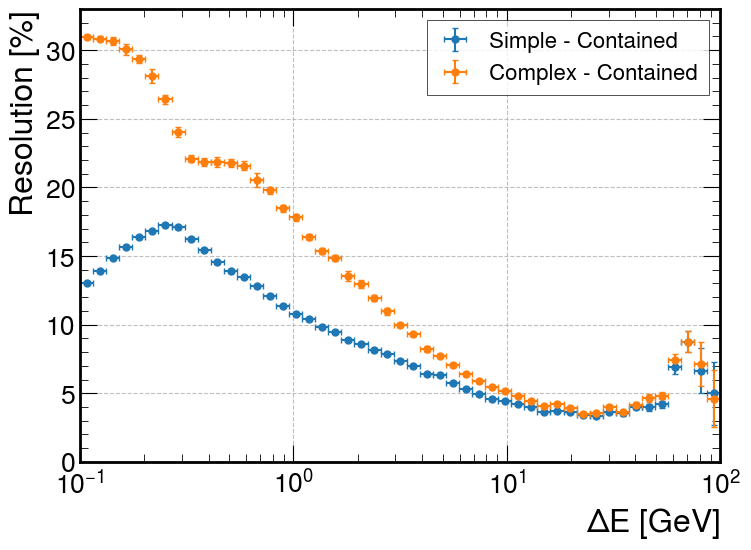

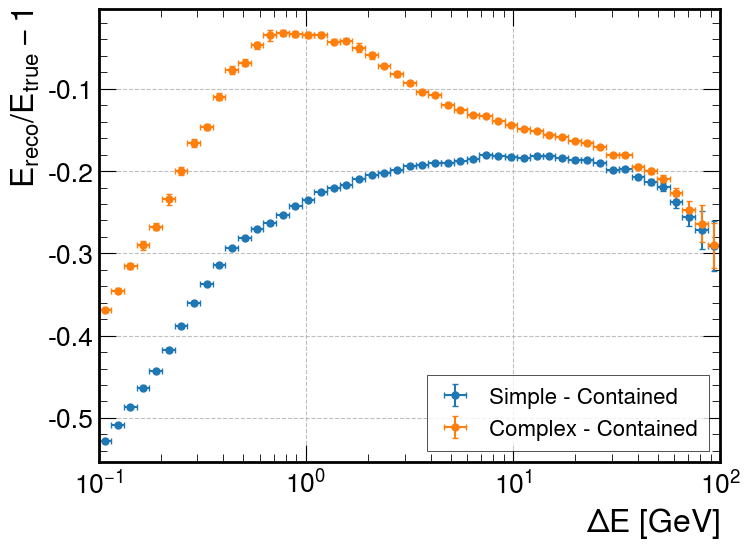

In [99]:
def the_res_scatter(labels = None, infotype="std", *args, **kargs):
    commonargs = dict(
        binsx= np.logspace(-1,2,50),
        xscale='log',
        legendsize=16,
        titlesize=20,
        colorscontained=['C0','C1'],
        colorsnotcontained=['C2','C3'],
    )
    for k in commonargs.keys():
        if k not in kargs.keys():
            kargs[k] = commonargs[k]
    
    x='enuvis_truth'
    y='Etotal'
    if 'x' in kargs.keys():
        x=kargs.pop('x')
    if 'y' in kargs.keys():
        y=kargs.pop('y')
    if labels is None:
        labels = [ i for i, _ in enumerate(args)]
    figsize = kargs.pop('figsize',(8,6))
    plts = []
    plts.append(plt.figure(figsize=figsize))
    thecolors_c = kargs.pop('colorscontained')
    thecolors_nc = kargs.pop('colorsnotcontained')
    if kargs.pop("no_color", False):
        thecolors_c = [ None for _ in labels ]
        thecolors_nc = [ None for _ in labels ]
    separated = kargs.pop("separated", False)
    nolegend = kargs.pop("nolegend", False)
    for df, label, c in zip(args, labels, thecolors_c):
        tlabel = f"{label} - Contained"
        title=''
        if separated:
            tlabel = label
            title = ''
        plot_res_scatter(
            df[x],
            df[y],
            label=tlabel,
            infotype=infotype,
            color=c,
            title=title,
            nolegend=nolegend,
            **kargs,
        )
    return plts
commonargs = dict(
    binsx= np.logspace(-1,2,50),
    xscale='log',
    capsize=2,
)
the_res_scatter(["Simple","Complex"], "std", dfsimple_en, dfcomplex_en, **commonargs)
plt.ylim(0,33)
# plt.savefig('graphs/numu_res.png')
the_res_scatter(["Simple","Complex"], "mean", dfsimple_en, dfcomplex_en, **commonargs)
# plt.ylim(-0.7,0.)
# plt.savefig('graphs/numu_bias.png')


[<Figure size 920x600 with 1 Axes>]

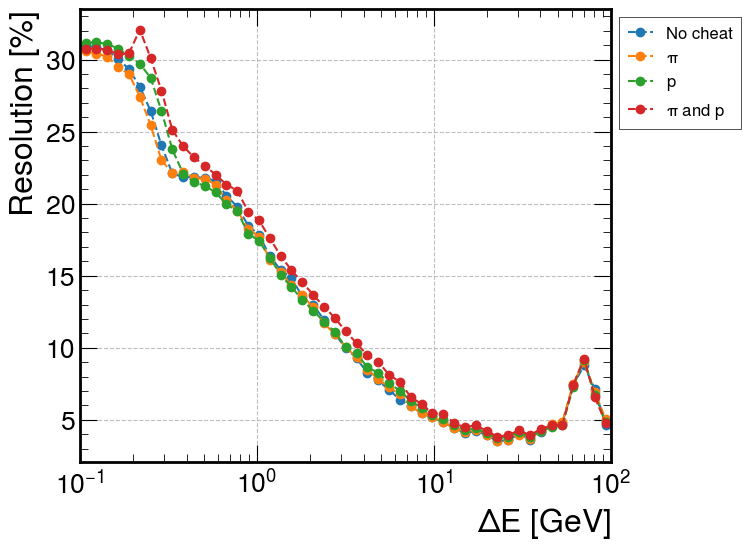

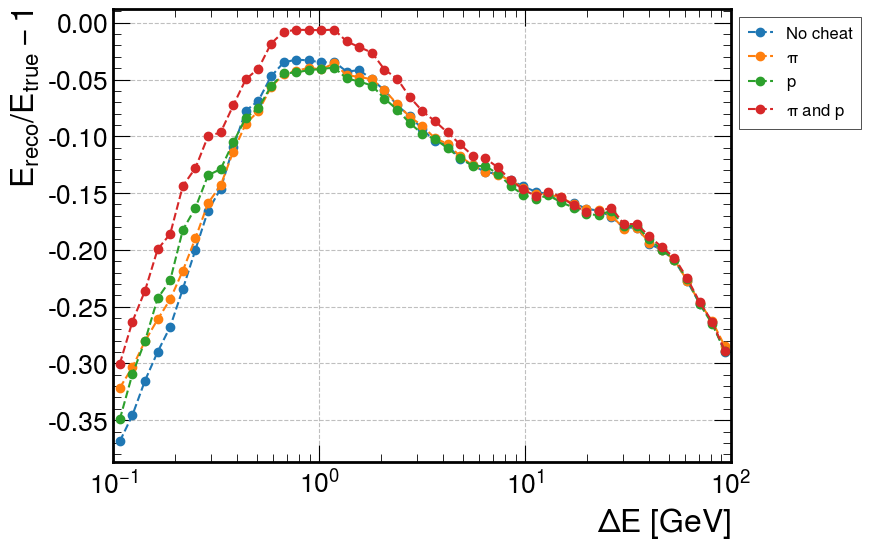

In [101]:
tmpargs = commonargs.copy()
tmpargs['no_color']=True
tmpargs['separated']=True
tmpargs['legendsize']=12
tmpargs['titlesize']=16
tmpargs['leg_ancor']=(1,1)
# tmpargs['capsize']=2
tmpargs.pop('capsize',None)
tmpargs['loc']="upper left"
tmpargs['fmt']="o--"
dataframes = (
    dfcomplex_en,
    dfcomplex_cheat_pi_en,
    dfcomplex_cheat_pr_en,
    dfcomplex_cheat_pi_pr_en,
)
labels = [
    "No cheat",
    r"$\pi$",
    r"$p$",
    r"$\pi$ and $p$",
]
# labels = None
tmpargs['nolegend'] = False
the_res_scatter( labels, "std", *dataframes, **tmpargs)
# plt.ylim(0,44)
# plt.savefig('graphs/numu_res.png')
tmpargs['figsize'] = (9.2,6)
tmpargs['nolegend'] = False
the_res_scatter( labels, "mean", *dataframes, **tmpargs)
# plt.ylim(-0.85,0.15)

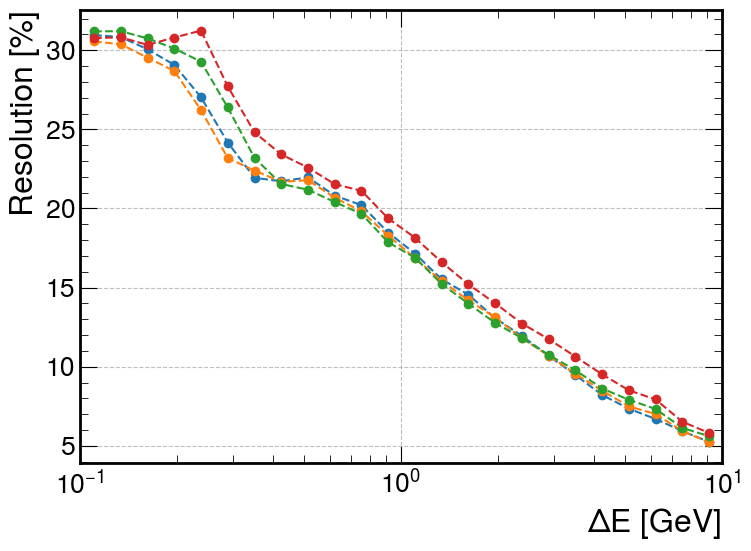

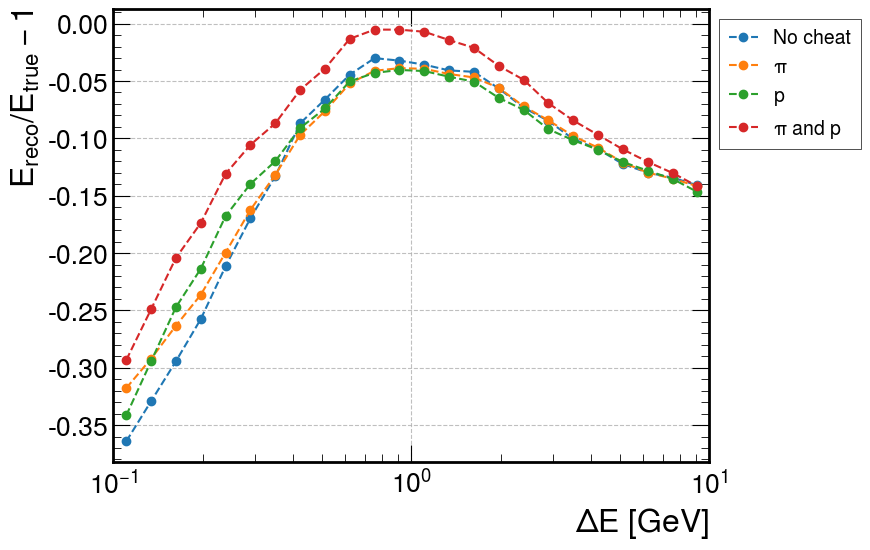

In [102]:
# tmpargs.pop('fmt',0)
# tmpargs['capsize'] = 2
tmpargs['legendsize']=14
tmpargs['titlesize']=18
tmpargs['binsx'] = np.logspace(-1, 1, 25)
tmpargs['figsize'] = (8,6)
tmpargs['nolegend'] = True
plts = the_res_scatter( labels, "std", *dataframes, **tmpargs)
pnames = ['c', 'nc']
for i, pt in enumerate(plts):
    pt.savefig(f"./cheat_plots/nc/res_{pnames[i]}.png", dpi=200)
tmpargs['figsize'] = (9.2,6)
tmpargs['nolegend'] = False
plts = the_res_scatter( labels, "mean", *dataframes, **tmpargs)
for i, pt in enumerate(plts):
    pt.savefig(f"./cheat_plots/nc/bias_{pnames[i]}.png", dpi=200)
# plt.ylim(-0.85,0.15)

[<Figure size 920x600 with 1 Axes>]

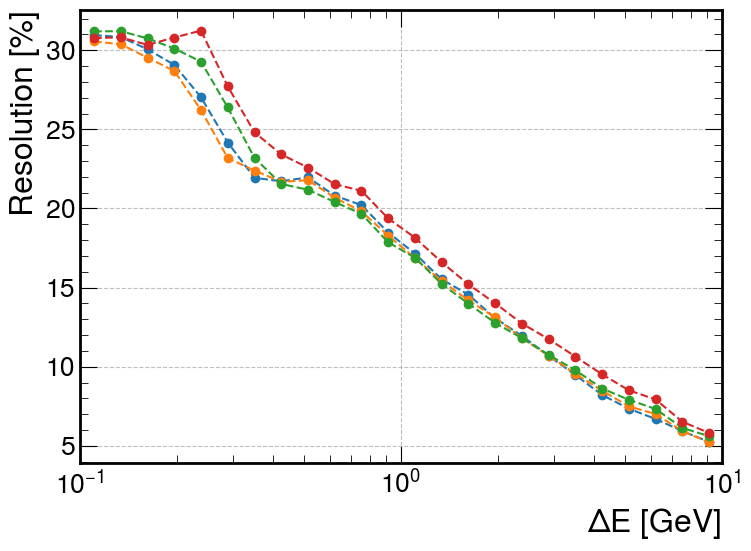

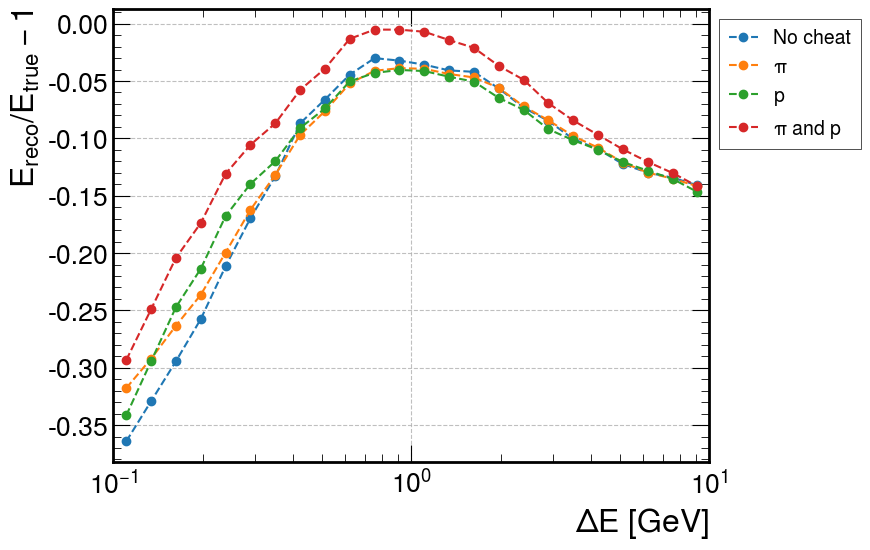

In [103]:
# tmpargs.pop('fmt',0)
# tmpargs['capsize'] = 2
tmpargs['binsx'] = np.logspace(-1, 1, 25)
tmpargs['figsize'] = (8,6)
tmpargs['nolegend'] = True
plts = the_res_scatter( labels, "std", *dataframes, **tmpargs)
tmpargs['figsize'] = (9.2,6)
tmpargs['nolegend'] = False
the_res_scatter( labels, "mean", *dataframes, **tmpargs)
# plt.ylim(-0.85,0.15)